In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-12-05 11:03:28.324570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 11:03:28.342544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733396608.362724   26424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733396608.368802   26424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 11:03:28.389209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.keras.preprocessing.image import load_img

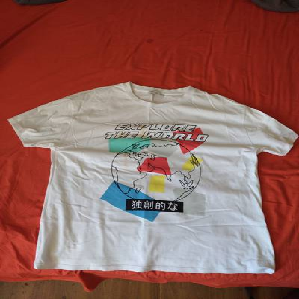

In [3]:
path = './clothing-dataset-small/train/t-shirt'
name = '00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'

full_name = f'{path}/{name}'
load_img(full_name, target_size=(299, 299))

In [4]:
img = load_img(full_name, target_size=(299, 299))

In [5]:
x = np.array(img)

In [6]:
x.shape

(299, 299, 3)

### Pre-trained convolutional neural network

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1733394596.882322   17621 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [9]:
X = np.array([x])
X = preprocess_input(X)

In [10]:
pred = model.predict(X)

I0000 00:00:1733394599.868375   17672 service.cc:148] XLA service 0x7f1fc8001510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733394599.868411   17672 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-05 10:29:59.904233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733394600.222972   17672 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-05 10:30:01.352954: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1733394602.195449   17672 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.8878355)),
  ('n03710637', 'maillot', np.float32(0.0068344995)),
  ('n04456115', 'torch', np.float32(0.006463632)),
  ('n02730930', 'apron', np.float32(0.0059278477)),
  ('n04235860', 'sleeping_bag', np.float32(0.0054279123))]]

### Convolution neural networks and transfer learning

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [14]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [15]:
X, y = next(train_ds)

In [16]:
X.shape

(32, 150, 150, 3)

In [17]:
y[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False)

Found 341 images belonging to 10 classes.


In [19]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

In [20]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [21]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [22]:
model.compile(optimizer= optimizer, loss=loss, metrics=["accuracy"])

In [23]:
history = model.fit(train_ds, epochs=10, validation_data =val_ds )

Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.6033 - loss: 1.5966 - val_accuracy: 0.7683 - val_loss: 0.9314
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8283 - loss: 0.5658 - val_accuracy: 0.7801 - val_loss: 0.9548
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8560 - loss: 0.4459 - val_accuracy: 0.7713 - val_loss: 1.1518
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8927 - loss: 0.3270 - val_accuracy: 0.8065 - val_loss: 0.8769
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9462 - loss: 0.1488 - val_accuracy: 0.7889 - val_loss: 0.9020
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9769 - loss: 0.0776 - val_accuracy: 0.8006 - val_loss: 0.9140
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9805 - loss: 0.0662 - val_accuracy: 0.7977 - val_loss: 0.9382
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9855 - loss: 0.0484 - val_accuracy: 0.7918 - val_loss: 

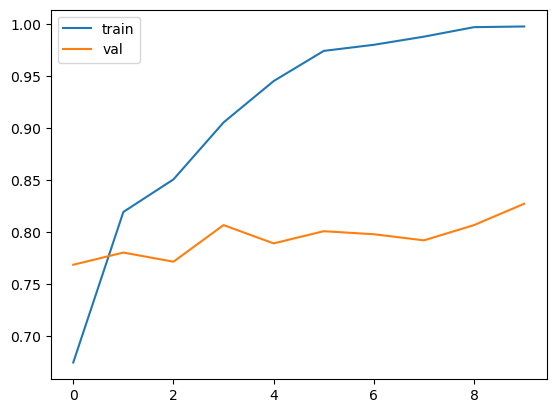

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.legend();

### Adjusting learning rate

In [25]:
def make_model(learning_rate=learning_rate):
    base_model = Xception(
        weights='imagenet', 
        include_top=False, 
        input_shape=(150, 150, 3))

    base_model.trainable = False
    #################################################
    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    outputs = keras.layers.Dense(10)(vectors)
    
    model = keras.Model(inputs, outputs)

    #################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer= optimizer, loss=loss, metrics=["accuracy"])

    return model

In [26]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    print()
    print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.2339 - loss: 2.2105 - val_accuracy: 0.5308 - val_loss: 1.6149
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5328 - loss: 1.4975 - val_accuracy: 0.6393 - val_loss: 1.2507
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6315 - loss: 1.1951 - val_accuracy: 0.6833 - val_loss: 1.0671
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6583 - loss: 1.0542 - val_accuracy: 0.6979 - val_loss: 0.9564
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6922 - loss: 0.9599 - val_accuracy: 0.7419 - val_loss: 0.8834
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7175 - loss: 0.8728 - val_accuracy: 0.7449 - val_loss: 0.8356
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7527 - loss: 0.7720 - val_accuracy: 0.7566 - val_loss: 0.7890
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7577 - loss: 0.7484 - val_accuracy: 0

In [27]:
del scores[0.1]
del scores[0.0001]

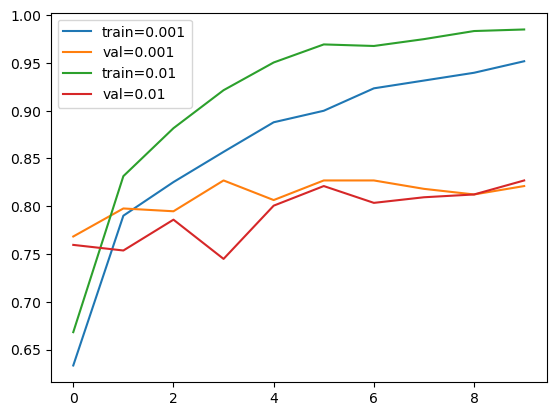

In [28]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'train={lr}')
    plt.plot(hist['val_accuracy'], label=f'val={lr}')
    
    plt.legend();

In [29]:
learning_rate = 0.001

### Checkpointing

In [30]:
model.save_weights('model_v1.weights.h5')

In [31]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras",
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [32]:
model = make_model(learning_rate=learning_rate)

history = model.fit(
        train_ds, 
        epochs=10, 
        validation_data=val_ds,
        callbacks = [checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.5145 - loss: 1.4626 - val_accuracy: 0.7830 - val_loss: 0.7064
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9508 - loss: 0.2183 - val_accuracy: 0.8182 - val_loss: 0.5429
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9439 - loss: 0.2135 - val_accuracy: 0.8211 - val_loss: 0.5259


### Adding more layer

In [33]:
def make_model(learning_rate=learning_rate, size_inner=100):
    base_model = Xception(
        weights='imagenet', 
        include_top=False, 
        input_shape=(150, 150, 3))

    base_model.trainable = False
    #################################################
    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)

    #################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer= optimizer, loss=loss, metrics=["accuracy"])

    return model

In [34]:
learning_rate = 0.001
scores = {}

for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    print()
    print()

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.3053 - loss: 1.9092 - val_accuracy: 0.6364 - val_loss: 1.1149
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6791 - loss: 0.9983 - val_accuracy: 0.7419 - val_loss: 0.8154
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7718 - loss: 0.7095 - val_accuracy: 0.7683 - val_loss: 0.7098
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8098 - loss: 0.5763 - val_accuracy: 0.7830 - val_loss: 0.6462
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8358 - loss: 0.4914 - val_accuracy: 0.7859 - val_loss: 0.6214
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8608 - loss: 0.4072 - val_accuracy: 0.7947 - val_loss: 0.5790
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8853 - loss: 0.3617 - val_accuracy: 0.8065 - val_loss: 0.5686
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9132 - loss: 0.3149 - val_accuracy: 0.809

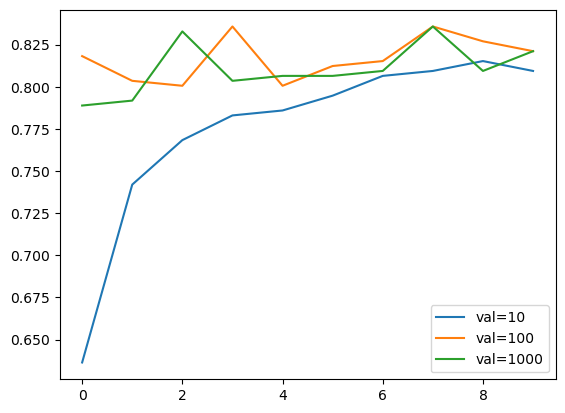

In [35]:
for size, hist in scores.items():
    #plt.plot(hist['accuracy'], label=f'train={size}')
    plt.plot(hist['val_accuracy'], label=f'val={size}')
    
    plt.legend();

### Regularization and dropout

In [36]:
def make_model(learning_rate=learning_rate, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet', 
        include_top=False, 
        input_shape=(150, 150, 3))

    base_model.trainable = False
    #################################################
    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    drop  = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)

    #################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer= optimizer, loss=loss, metrics=["accuracy"])

    return model

In [37]:
learning_rate = 0.001
size = 100


scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(
        learning_rate=learning_rate, 
        size_inner=size, 
        droprate=droprate
    )
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[droprate] = history.history
    print()
    print()

0.0
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5814 - loss: 1.2742 - val_accuracy: 0.7713 - val_loss: 0.6652
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8150 - loss: 0.5028 - val_accuracy: 0.7830 - val_loss: 0.6065
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8731 - loss: 0.3596 - val_accuracy: 0.8035 - val_loss: 0.5693
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9124 - loss: 0.2648 - val_accuracy: 0.8094 - val_loss: 0.5943
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9638 - loss: 0.1610 - val_accuracy: 0.8006 - val_loss: 0.5803
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9769 - loss: 0.1147 - val_accuracy: 0.8240 - val_loss: 0.5929
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9865 - loss: 0.0860 - val_accuracy: 0.8270 - val_loss: 0.6056
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9961 - loss: 0.0599 - val_accuracy: 0.80

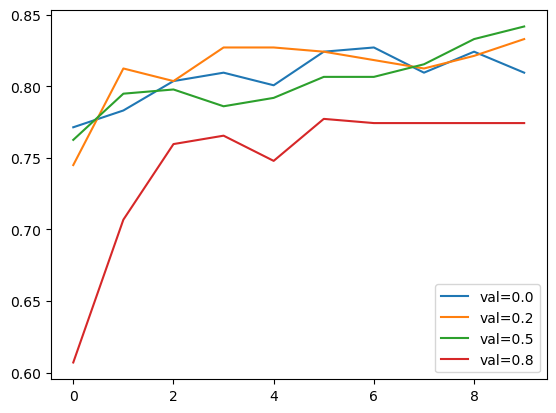

In [38]:
for droprate, hist in scores.items():
    #plt.plot(hist['accuracy'], label=f'train={droprate}')
    plt.plot(hist['val_accuracy'], label=f'val={droprate}')
    
    plt.legend();

### Data Augumentation

In [39]:
 train_gen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     rotation_range = 30,
     width_shift_range = 10.0,
     height_shift_range = 10.0,
     shear_range= 10,
     zoom_range = 0.1,
     vertical_flip=False
 )

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [41]:
model = make_model(
        learning_rate=learning_rate, 
        size_inner=size, 
        droprate=droprate
    )

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2530 - loss: 2.2123

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 247ms/step - accuracy: 0.2537 - loss: 2.2101 - val_accuracy: 0.5572 - val_loss: 1.3977
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.4175 - loss: 1.6965 - val_accuracy: 0.5982 - val_loss: 1.1882
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.4248 - loss: 1.6145 - val_accuracy: 0.6188 - val_loss: 1.0921
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.4772 - loss: 1.5328 - val_accuracy: 0.6628 - val_loss: 1.0356
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.4787 - loss: 1.4594 - val_accuracy: 0.6804 - val_loss: 0.9830
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.4874 - loss: 1.4179 - val_accuracy: 0.6891 - val_loss: 0.9377
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.5108 - loss: 1.3591 - val_accuracy: 0.7126 - val_loss: 0.8865
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.5419 - loss: 1.3161 - val_accuracy: 0.724

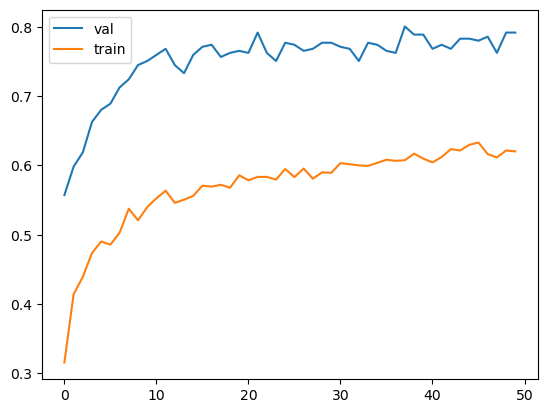

In [42]:
hist = history.history

plt.plot(hist["val_accuracy"], label='val')
plt.plot(hist["accuracy"], label='train')
plt.legend();

### Train a bigger model

In [18]:
learning_rate = 0.001
size = 100

In [19]:
 def make_model(input_size=150, learning_rate=learning_rate, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet', 
        include_top=False, 
        input_shape=(input_size, input_size, 3))

    base_model.trainable = False
    #################################################
    inputs = keras.Input(shape=(input_size, input_size, 3))

    base = base_model(inputs, training=False)
    
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    drop  = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)

    #################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer= optimizer, loss=loss, metrics=["accuracy"])

    return model

In [20]:
train_gen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     rotation_range = 30,
     width_shift_range = 10.0,
     height_shift_range = 10.0,
     shear_range= 10,
     zoom_range = 0.1,
     vertical_flip=False
 )

input_size = 299

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(input_size, input_size), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(input_size, input_size), batch_size=32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [21]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v4_{epoch:02d}_{val_accuracy:.3f}.keras",
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [22]:
size = 100
droprate = 0.5

In [23]:
model = make_model(
        input_size = 299,
        learning_rate=learning_rate, 
        size_inner=size, 
        droprate=droprate
    )

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks = [checkpoint])

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 636ms/step - accuracy: 0.5013 - loss: 1.4672 - val_accuracy: 0.8211 - val_loss: 0.5621
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 600ms/step - accuracy: 0.7443 - loss: 0.7573 - val_accuracy: 0.8475 - val_loss: 0.4820
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 605ms/step - accuracy: 0.7850 - loss: 0.6763 - val_accuracy: 0.8680 - val_loss: 0.4360
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 599ms/step - accuracy: 0.8011 - loss: 0.5993 - val_accuracy: 0.8651 - val_loss: 0.4009
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.8115 - loss: 0.5603 - val_accuracy: 0.8710 - val_loss: 0.3981
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 591ms/step - accuracy: 0.8172 - loss: 0.5335 - val_accuracy: 0.8592 - val_loss: 0.4103
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 592ms/step - accuracy: 0.8338 - loss: 0.4708 - val_accuracy: 0.8534 - val_loss: 0.3774
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 597ms/step - accuracy: 0.8476 - loss: 0.4676 - val_accu

### Using the model

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [31]:
model = keras.models.load_model('xception_v4_46_0.889.keras')

In [35]:
test_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test/', 
    target_size=(299, 299), 
    batch_size=32, 
    shuffle=False)

Found 372 images belonging to 10 classes.


In [36]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8647 - loss: 0.3566


[0.2764136493206024, 0.9005376100540161]

In [41]:
path = 'clothing-dataset-small/test/skirt/5144499e-7848-4441-8873-7daab5386eec.jpg'

In [42]:
img = load_img(path, target_size=(299, 299))

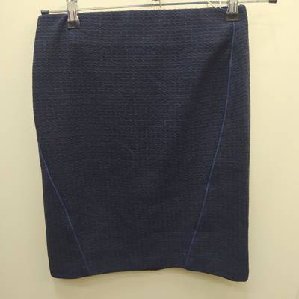

In [43]:
img

In [44]:
import numpy as np
x = np.array(img)
X = np.array([x])

In [46]:
X = preprocess_input(X)

In [47]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [48]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [54]:
label = ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts','skirt', 't-shirt']

In [57]:
dict(zip(label, pred[0]))

{'dress': np.float32(-3.993569),
 'hat': np.float32(-5.3520265),
 'longsleeve': np.float32(0.88279647),
 'outwear': np.float32(-6.1812825),
 'pants': np.float32(0.9306006),
 'shirt': np.float32(-4.1128664),
 'shoes': np.float32(-9.020778),
 'shorts': np.float32(-1.4706532),
 'skirt': np.float32(7.091582),
 't-shirt': np.float32(-3.3703701)}

### The model prediction is skirt which is correct